# Kindle data: data pre-processing
---

We are using Amazon Kindle review data, the source of which can be found <a href='https://nijianmo.github.io/amazon/index.html'>here</a>.

Before inputting our data straight into any neural network, it is important to get a grasp of the raw data and make any necessary amendments.

In [29]:
# imports
import pandas as pd
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# scraping data from online repository

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

### The below cell takes a VERY long time to run, since we are scraping extracting the (very large) dataset from the online source.

In [3]:
df = getDF('Kindle_Store_5.json.gz')

In [4]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"07 3, 2014",A2LSKD2H9U8N0J,B000FA5KK0,{'Format:': ' Kindle Edition'},sandra sue marsolek,"pretty good story, a little exaggerated, but I...",pretty good story,1404345600,NaN,NaN
1,5.0,True,"05 26, 2014",A2QP13XTJND1QS,B000FA5KK0,{'Format:': ' Kindle Edition'},Tpl,"If you've read other max brand westerns, you k...",A very good book,1401062400,NaN,NaN
2,5.0,True,"09 16, 2016",A8WQ7MAG3HFOZ,B000FA5KK0,{'Format:': ' Kindle Edition'},Alverne F. Anderson,"Love Max, always a fun twist",Five Stars,1473984000,NaN,NaN
3,5.0,True,"03 3, 2016",A1E0MODSRYP7O,B000FA5KK0,{'Format:': ' Kindle Edition'},Jeff,"As usual for him, a good book",a good,1456963200,NaN,NaN
4,5.0,True,"09 10, 2015",AYUTCGVSM1H7T,B000FA5KK0,{'Format:': ' Kindle Edition'},DEHS - EddyRapcon,MB is one of the original western writers and ...,A Western,1441843200,2,NaN


In [5]:
df.describe()

,overall,unixReviewTime
count,2.222983e+06,2.222983e+06
mean,4.394687e+00,1.433041e+09
std,9.260669e-01,4.430677e+07
min,1.000000e+00,8.820576e+08
25%,4.000000e+00,1.404778e+09
50%,5.000000e+00,1.434672e+09
75%,5.000000e+00,1.462234e+09
max,5.000000e+00,1.538525e+09


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2222983 entries, 0 to 2222982
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   overall         float64
 1   verified        bool   
 2   reviewTime      object 
 3   reviewerID      object 
 4   asin            object 
 5   style           object 
 6   reviewerName    object 
 7   reviewText      object 
 8   summary         object 
 9   unixReviewTime  int64  
 10  vote            object 
 11  image           object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 205.6+ MB


We begin by removing any unverified reviews and removing unnecessary columns:

In [7]:
# cleaning up the dataset

# only include verified reviews
df_new = df[df["verified"] == True]

In [8]:
# removing unnecessary columns
df_new = df_new[["overall", "reviewTime", "reviewText", "summary"]]

In [9]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1418037 entries, 0 to 2222982
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   overall     1418037 non-null  float64
 1   reviewTime  1418037 non-null  object 
 2   reviewText  1417696 non-null  object 
 3   summary     1417127 non-null  object 
dtypes: float64(1), object(3)
memory usage: 54.1+ MB


In [10]:
df_new.head()

,overall,reviewTime,reviewText,summary
0,4.0,"07 3, 2014","pretty good story, a little exaggerated, but I...",pretty good story
1,5.0,"05 26, 2014","If you've read other max brand westerns, you k...",A very good book
2,5.0,"09 16, 2016","Love Max, always a fun twist",Five Stars
3,5.0,"03 3, 2016","As usual for him, a good book",a good
4,5.0,"09 10, 2015",MB is one of the original western writers and ...,A Western


## 5-category classification problem

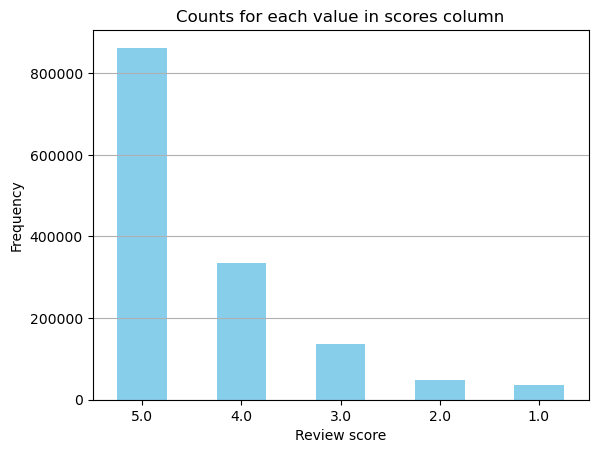

In [63]:
value_counts = df_new['overall'].value_counts()

# Plotting bar chart of counts for each value in 'Category' column
#plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Counts for each value in scores column')
plt.xlabel('Review score')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x labels if needed
plt.grid(axis='y')
plt.show()

An imbalanced dataset will make it extremely difficult for our resultant model to learn properly. We utilise undersampling to mitigate the problem:

In [12]:
count_specific_value = (df_new['overall'] == 1).sum()
print(count_specific_value)

36293


In [13]:
count_other_values = (df_new['overall'] == 2).sum()
print(count_other_values)

49397


In [14]:
df_new.overall.unique()

array([4., 5., 3., 2., 1.])

In [15]:
# Calculate the minimum count among the different score values
min_count = df_new['overall'].value_counts().min()

# Undersample each score value to have the same count as the minimum count
balanced_df = pd.concat([
    df_new[df_new['overall'] == score].sample(min_count) for score in df_new['overall'].unique()
])

# Shuffle the balanced DataFrame
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

In [16]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181465 entries, 0 to 181464
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     181465 non-null  float64
 1   reviewTime  181465 non-null  object 
 2   reviewText  181432 non-null  object 
 3   summary     181401 non-null  object 
dtypes: float64(1), object(3)
memory usage: 5.5+ MB


In [17]:
balanced_df.head()

,overall,reviewTime,reviewText,summary
0,1.0,"05 6, 2016",This reading did not have any real imagination...,This reading did not have any real imagination...
1,4.0,"05 19, 2013","This is a good read,I just wish we would get m...",good read
2,1.0,"09 16, 2016",Really?,One Star
3,3.0,"12 5, 2014",I thought the book was kind of disjointed. It...,"The book had a good story, but just a confusin..."
4,1.0,"04 29, 2015",Really a waste of time. Horribly boring.,Save your time...not worth it.


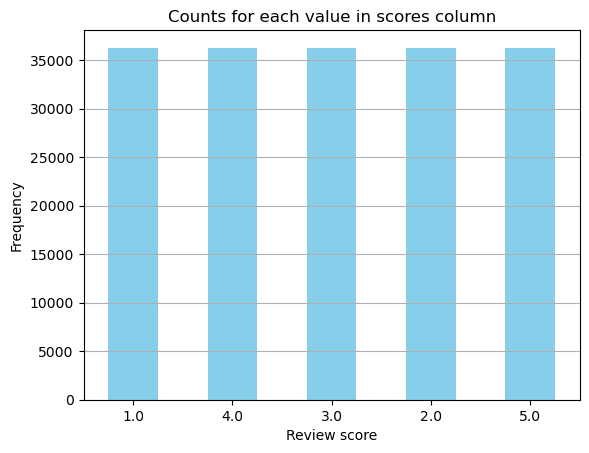

In [64]:
value_counts_balanced = balanced_df['overall'].value_counts()

# Plotting bar chart of counts for each value in 'Category' column
# plt.figure(figsize=(8, 6))
value_counts_balanced.plot(kind='bar', color='skyblue')
plt.title('Counts for each value in scores column')
plt.xlabel('Review score')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x labels if needed
plt.grid(axis='y')
plt.show()

In [19]:
balanced_df.to_csv("kindle_balanced.csv", index=False)

## 3-category classification problem

A simplified version of our original problem involves grouping the review scores into 'Positive', 'Negative' and 'Neutral' sentiment. That is, we group together the 4 and 5 star reviews for positive, 1 and 2 star reviews for negative and relabel 3 start reviews as neutral.

In [20]:
# df_one = df_new[df_new['overall'] == 1]
# df_two = df_new[df_new['overall'] == 2]
# df_three = df_new[df_new['overall'] == 3]
# df_four = df_new[df_new['overall'] == 4]
# df_five = df_new[df_new['overall'] == 5]

In [33]:
df_sent = df_new.copy()

In [34]:
scores_to_sentiment = {1:'Negative', 2:'Negative', 3:'Neutral', 4:'Positive', 5:'Positive'}

# replace scores with sentiment labels
df_sent['overall'] = df_sent['overall'].replace(scores_to_sentiment)

In [36]:
df_sent['overall'].value_counts()

overall
Positive    1197045
Neutral      135302
Negative      85690
Name: count, dtype: int64

In [39]:
df_sent.head()

,overall,reviewTime,reviewText,summary
0,Positive,"07 3, 2014","pretty good story, a little exaggerated, but I...",pretty good story
1,Positive,"05 26, 2014","If you've read other max brand westerns, you k...",A very good book
2,Positive,"09 16, 2016","Love Max, always a fun twist",Five Stars
3,Positive,"03 3, 2016","As usual for him, a good book",a good
4,Positive,"09 10, 2015",MB is one of the original western writers and ...,A Western


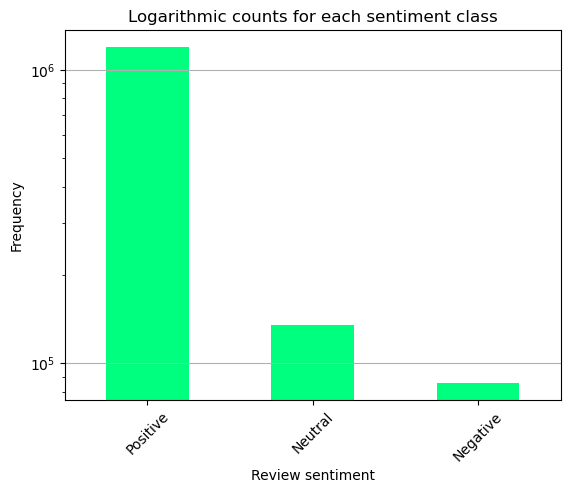

In [65]:
df_sent['overall'].value_counts().plot(kind='bar', color='springgreen')
plt.title('Logarithmic counts for each sentiment class')
plt.xlabel('Review sentiment')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.grid(axis='y')
plt.show()

In [45]:
# Calculate the minimum count among the different score values
min_count_sent = df_sent['overall'].value_counts().min()

# Undersample each score value to have the same count as the minimum count
balanced_df_sent = pd.concat([
    df_sent[df_sent['overall'] == score].sample(min_count_sent) for score in df_sent['overall'].unique()
])

# Shuffle the balanced DataFrame
balanced_df_sent = balanced_df_sent.sample(frac=1).reset_index(drop=True)

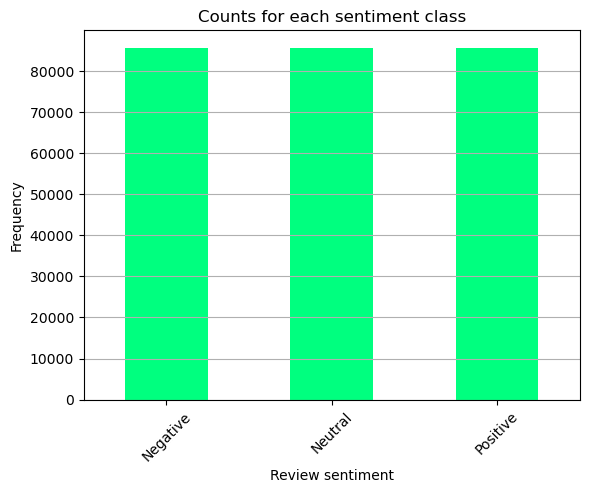

In [66]:
balanced_df_sent['overall'].value_counts().plot(kind='bar', color='springgreen')
plt.title('Counts for each sentiment class')
plt.xlabel('Review sentiment')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.grid(axis='y')
plt.show()

In [54]:
balanced_df_sent.to_csv('three_class_balanced.csv', index=False)